# Task 3

# Imports

In [179]:
import numpy as np
import pandas as pd
from joblib import dump, load
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16, 'axes.labelweight': 'bold', 'figure.figsize': (8,6)})

## Part 1:

Recall as a final goal of this project. We want to build and deploy ensemble machine learning models in the cloud, where features are outputs of different climate models and the target is the actual rainfall observation. In this milestone, you'll actually build these ensemble machine learning models in the cloud.  

**Your tasks:**

1. Read the data CSV from your s3 bucket. 
2. Drop rows with nans. 
3. Split the data into train (80%) and test (20%) portions with `random_state=123`. 
4. Carry out EDA of your choice on the train split. 
5. Train ensemble machine learning model using `RandomForestRegressor` and evaluate with metric of your choice (e.g., `RMSE`) by considering `Observed` as the target column. 
6. Discuss your results. Are you getting better results with ensemble models compared to the individual climate models? 

> Recall that individual columns in the data are predictions of different climate models. 

## 1. Read data from s3 bucket

In [190]:
## You could download it from your bucket, or you can use the file that I have in my bucket.
## You should be able to access it from my bucket using your key and secret
aws_credentials ={"key": "","secret": ""}
df = pd.read_csv("s3://mds-s3-student49/output/ml_data_SYD.csv", index_col=0, parse_dates=True)

## 2. Drop rows with nans

In [191]:
df = df.dropna()

## 3. Split data to train and test sets

In [193]:
train_df, test_df = train_test_split(df, test_size= 0.2, random_state=123)

X_train = train_df.drop(columns = ("Observed"))
y_train = train_df["Observed"]

X_test = test_df.drop(columns = ("Observed"))
y_test = test_df["Observed"]

## 4. EDA

Let's explore the data. We will start by looking at the mean predicted rainfall by model:

Text(0, 0.5, 'Rain (mm/day)')

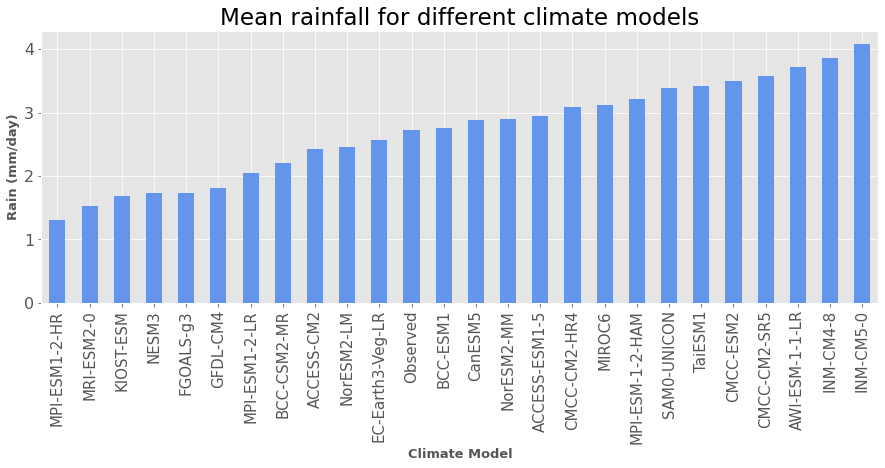

In [194]:
#mean values for baseline models
train_df.mean().sort_values().plot.bar(figsize=(15,5), color = "cornflowerblue")
plt.title("Mean rainfall for different climate models")
plt.xlabel("Climate Model", fontsize=13)
plt.ylabel("Rain (mm/day)", fontsize=13)

From this chart, we can see that most models predict a mean rainfall between 1.5 and 4.0 mm per day. This variability seems quite large, since the rightmost model is about three times as high as the leftmost model. There probably is room to improve on these predictions.

Let's now look a the average rainfall over time. For simplicity, let's simply average the models by time period (year):

Text(0, 0.5, 'Rain (mm/day)')

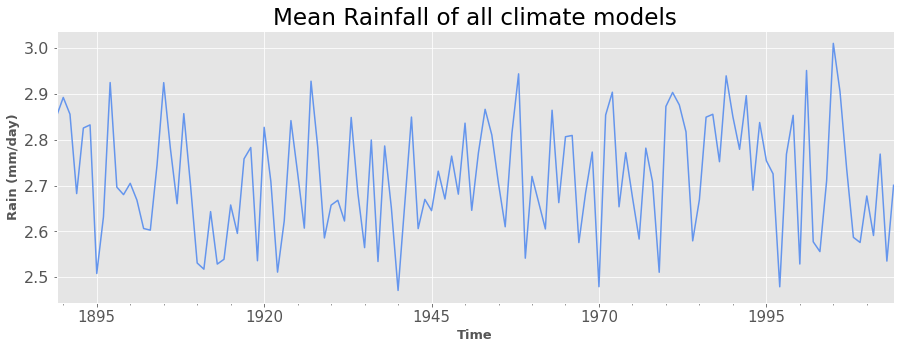

In [156]:
#time seris plot
train_df.mean(axis=1).resample("Y").mean().plot(figsize=(15,5), color = "cornflowerblue")
plt.title("Mean Rainfall of all climate models")
plt.xlabel("Time", fontsize=13)
plt.ylabel("Rain (mm/day)", fontsize=13)

The series seems fairly stationary, though there are clear differences from one year to the next. 

Let's explore if there is a correlation between the true observed rainfall and and the predicted rainfall for each of the reference models:

Text(0, 0.5, 'Correlation')

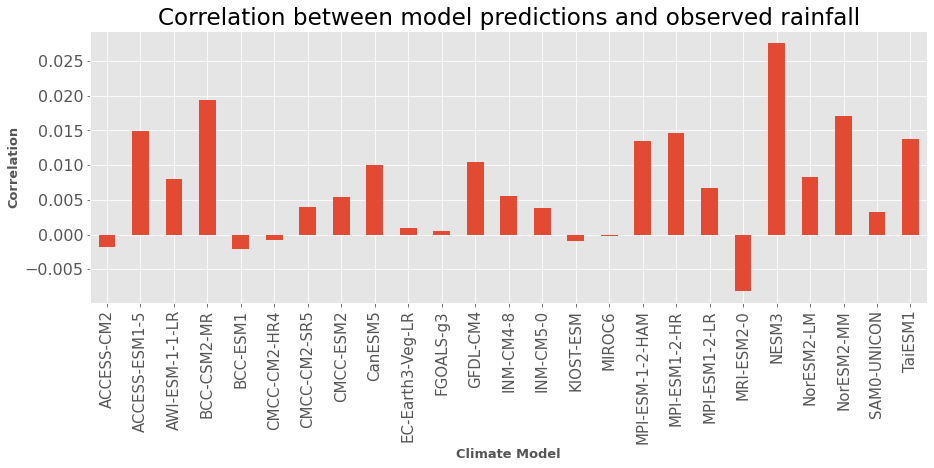

In [177]:
#correlation plot
train_df.corr()["Observed"][:-1].plot.bar(figsize=(15,5))
plt.title("Correlation between model predictions and observed rainfall")
plt.xlabel("Climate Model", fontsize=13)
plt.ylabel("Correlation", fontsize=13)

We see a positive correlation for almost all models, which is healthy sign that reference models contain useful information. However, the correlations appear to be fairly weak (at best 0.025). This probably reflects the fact that  daily rainfall in Australia is not easily forecasted, even if average rainfall over a longer time window is more predictable.  

## 5. Train ensemble machine learning model

Let's now train a vanilla random forest model with `sklearn`.

In [44]:
%%time
#fit RandomForest model with different climate models as features
model = RandomForestRegressor(random_state=123, criterion = "mse")
model.fit(X_train, y_train)

CPU times: user 2min 48s, sys: 163 ms, total: 2min 48s
Wall time: 2min 48s


RandomForestRegressor(random_state=123)

In [48]:
#predict
y_hat = model.predict(X_test)

In [58]:
#mse score for predicted values
rf_test_score = mean_squared_error(y_test, y_hat)
rf_test_score

78.2234398963254

In [54]:
#mse scores for baseline model test set
baseline_test_mse = X_test.apply(lambda x: mean_squared_error(x, y_test))
baseline_test_mse

ACCESS-CM2          121.859503
ACCESS-ESM1-5       114.389557
AWI-ESM-1-1-LR      120.925556
BCC-CSM2-MR         115.807330
BCC-ESM1            112.690499
CMCC-CM2-HR4        113.277788
CMCC-CM2-SR5        131.804508
CMCC-ESM2           126.483609
CanESM5             124.351889
EC-Earth3-Veg-LR    109.277885
FGOALS-g3            93.853232
GFDL-CM4            110.495462
INM-CM4-8           131.139950
INM-CM5-0           150.067964
KIOST-ESM            92.169209
MIROC6              128.890059
MPI-ESM-1-2-HAM     119.508715
MPI-ESM1-2-HR        99.397365
MPI-ESM1-2-LR       105.285782
MRI-ESM2-0           98.461859
NESM3                99.563211
NorESM2-LM          108.371119
NorESM2-MM          119.677911
SAM0-UNICON         136.393181
TaiESM1             132.896700
dtype: float64

In [100]:
#get mse scores for baseline model train set
baseline_train_mse = X_train.apply(lambda x: mean_squared_error(x, y_train))
baseline_train_mse

ACCESS-CM2          111.666622
ACCESS-ESM1-5       113.284866
AWI-ESM-1-1-LR      118.308166
BCC-CSM2-MR         105.982389
BCC-ESM1            101.429067
CMCC-CM2-HR4        107.193705
CMCC-CM2-SR5        119.585524
CMCC-ESM2           114.773506
CanESM5             111.752399
EC-Earth3-Veg-LR     98.052564
FGOALS-g3            86.208758
GFDL-CM4             97.804941
INM-CM4-8           122.953733
INM-CM5-0           135.134065
KIOST-ESM            84.576195
MIROC6              126.238733
MPI-ESM-1-2-HAM     112.679127
MPI-ESM1-2-HR        90.058675
MPI-ESM1-2-LR        93.739163
MRI-ESM2-0           92.333783
NESM3                87.832444
NorESM2-LM           98.371004
NorESM2-MM          114.133758
SAM0-UNICON         128.113276
TaiESM1             121.188550
dtype: float64

## 6. Discuss  results

Text(0, 0.5, 'MSE')

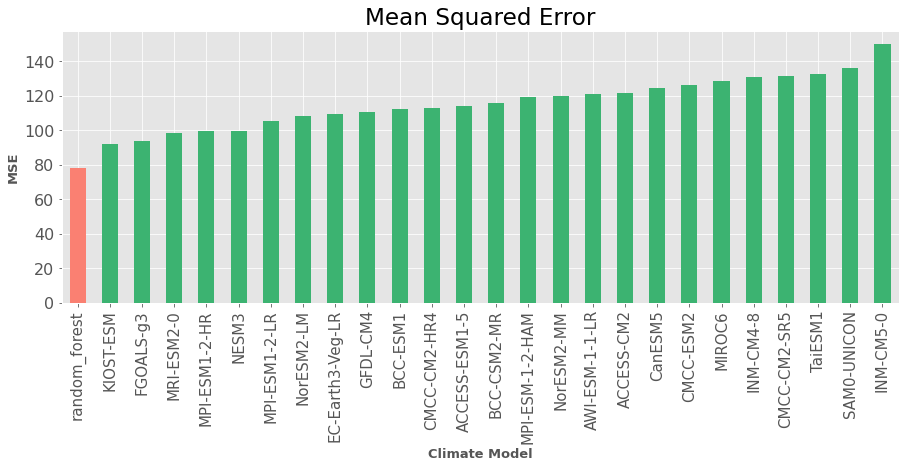

In [178]:
baseline_test_mse["random_forest"] = rf_test_score
baseline_test_mse.sort_values().plot(kind= "bar", color= ["salmon"] + ["mediumseagreen"]*25, figsize=(15,5))

plt.title("Mean Squared Error")
plt.xlabel("Climate Model", fontsize=13)
plt.ylabel("MSE", fontsize=13)

> Our random forest model with default parameters scored better than all the individual models in the training dataset when looking at the mean squared error metric. This result seems reasonable because we are leveraging the information from a multitude of other models for our model. In a sense we are ensembling all of these previous models to get our result. We should see even further improvement in the mean squared error and the RMSE once we tune the hyperparameters.

## Part 2:

### Preparation for deploying model next week

#### Complete task 4 from the milestone3 before coming here

We’ve found ```n_estimators=100, max_depth=5``` to be the best hyperparameter settings with MLlib (from the task 4 from milestone3), here we then use the same hyperparameters to train a scikit-learn model. 

In [195]:
model = RandomForestRegressor(n_estimators=100, max_depth=5)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5)

In [196]:
print(f"Train RMSE: {mean_squared_error(y_train, model.predict(X_train), squared=False):.2f}")
print(f" Test RMSE: {mean_squared_error(y_test, model.predict(X_test), squared=False):.2f}")


Train RMSE: 7.89
 Test RMSE: 8.65


In [197]:
# ready to deploy
dump(model, "model.joblib")

['model.joblib']

***Upload model.joblib to s3. You choose how you want to upload it.***

In [204]:
import boto3
s3 = boto3.resource('s3')
s3.meta.client.upload_file('model.joblib',
                           'mds-s3-student49',
                           'output/model.joblib')